# Deep Recurrent Learning (N-BEATS) vs. Traditional Machine Learning
## Advanced Machine Learning in Finance - Individual Project

The aim of this project is to compare the performance of two machine learning models, N-Beats and RandomForests, for predicting sales figures. The challenge is to use available data that has a correlation with the sales of various companies, such as credit card transactions to predict the quarterly sales figures.

The goal is to compare the accuracy of predictions for the current quarter, as well as the next couple of quarters, between N-Beats and RandomForests.

N-Beats is a deep learning model designed specifically for time-series forecasting, while RandomForests is a popular tree-based model used for various types of predictive modeling. This project aim to give insights into comparative forecasting results from these two models and their applications in the field of sales prediction.

The outcome of this project will be a comparison between the two models, including a discussion of the results and their implications for businesses and organizations looking to improve their financial forecasting capabilities.

In [176]:
import numpy as np
import data_wrangling as dw
import time_series_preprocessing as tsp
import visualisations as vis
import matplotlib.pyplot as plt

import darts
from darts.models import NBEATSModel
from darts.utils.likelihood_models import QuantileRegression
from darts.metrics import mape, rmse

from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
import skopt.plots as skplt
from models import HyperparameterOptimization

# Data Extraction

In [177]:
revenue = dw.create_df('revenue.xlsx')
spendings = dw.create_df('spend_amounts_aggregated.xlsx')
df = dw.merge_dataframes(df_left=spendings, df_right=revenue)
df = dw.encode_index(df, 'mic')
df = dw.add_time_cols(df)
df.head()

,mic,ticker,time,nw_total_sales_a_total,nw_total_sales_b_total,Sales_Actual_fiscal,Sales_Estimate_fiscal,year,month,quarter
0,0,FLWS,2019-03-31,54356.41,NaN,248.413,243.11867,2019,3,1
1,0,FLWS,2019-06-30,54514.94,NaN,259.398,255.14700,2019,6,2
2,0,FLWS,2019-12-29,41047.13,NaN,605.642,610.46940,2019,12,4
3,0,FLWS,2020-03-29,60962.10,NaN,278.776,266.56613,2020,3,1
4,0,FLWS,2020-06-28,58101.76,33479.59,417.956,372.81314,2020,6,2


## Data Exploration

In [178]:
df.shape

(4009, 10)

In [179]:
df.columns

Index(['mic', 'ticker', 'time', 'nw_total_sales_a_total',
       'nw_total_sales_b_total', 'Sales_Actual_fiscal',
       'Sales_Estimate_fiscal', 'year', 'month', 'quarter'],
      dtype='object')

In [180]:
# total number of companies
len(df['ticker'].unique())

267

In [181]:
df.isna().sum()

mic                         0
ticker                      0
time                        0
nw_total_sales_a_total    193
nw_total_sales_b_total    806
Sales_Actual_fiscal       142
Sales_Estimate_fiscal     180
year                        0
month                       0
quarter                     0
dtype: int64

In [182]:
dw.print_nans_companies(df)



Ticker: AAL, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AAN, # Data points: 12
Column: Sales_Actual_fiscal, NaN Indices: [0, 1]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2]


Ticker: AAP, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 3]


Ticker: AAPL, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: ABNB, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7]


Ticker: ACI, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6]


Ticker: AD, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 3]


Ticker: ADBE, # Data points: 18
Column: nw_total_sales_b_total, NaN

We see that the vast majority of missing vals are happening in the column 'nw_total_sales_b_total' for the indices in some form of subset of [0,1,2,3] so that it makes sense to impute these values to avoid missing large amounts of data.

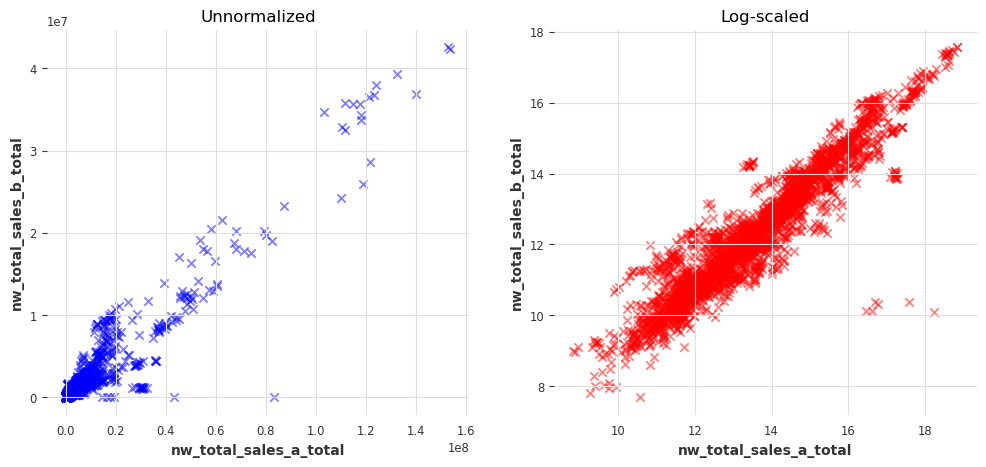

In [183]:
vis.plot_scatter_log(df,'nw_total_sales_a_total', 'nw_total_sales_b_total')

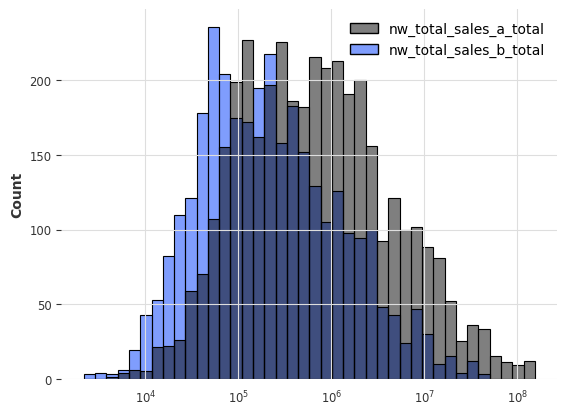

In [184]:
vis.plot_hist(df, 'nw_total_sales_a_total','nw_total_sales_b_total' )


We see that the distributions are quite similar but shifted, and that they have a fairly linear relationship when we apply the log. Thus, a linear least squares approach is justified. Including the other columns give a higher degree of freedom, but it could be justified to just use these columns up against each other.

Based on the plots a LLS solution looks sensible to the following time series, and thus handles many of the missing datapoints. The accuracy of these are however unknown. Bayesian regression can be performed to quantify uncertainty on the imputation on the missing values. To avoid noisy inputs, one could also perform lasso/ridge regression to shrink mutual information features and reduce high variance issues.   

We see that the Actual and Estimated sales for fiscal quarters have a decent amount of NaN values. Thus, we can statistically inspect them as well, and see if there are favorable methods of imputation of these.

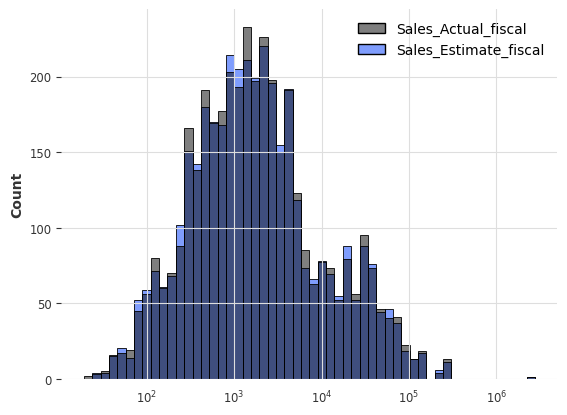

In [185]:
vis.plot_hist(df, 'Sales_Actual_fiscal', 'Sales_Estimate_fiscal')

The distributions have a very large overlap. Note that the distribution is a concetanation of all companies, so even though this looks normal, it is not necessarily the case for the distribution of actual sales and estimated sales with respect to the company in question.

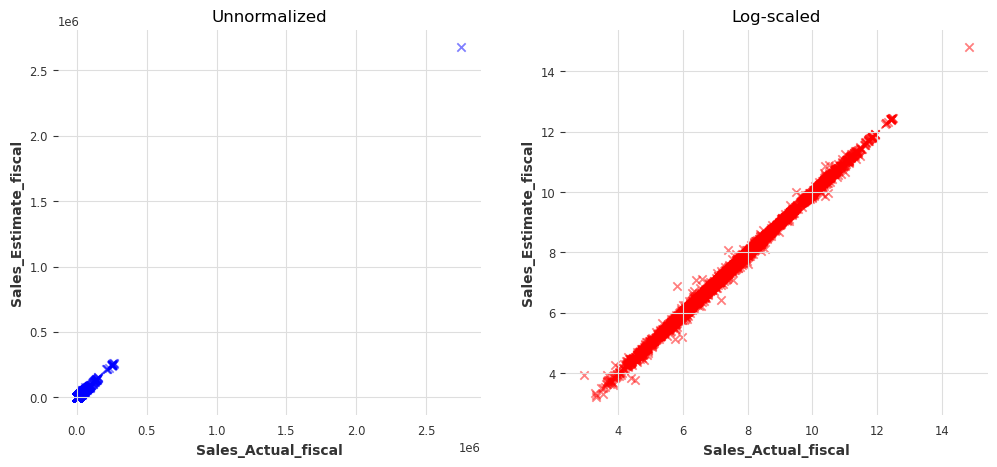

In [186]:
vis.plot_scatter_log(df, 'Sales_Actual_fiscal', 'Sales_Estimate_fiscal')

From this it looks as they are very linearly correlated. Let's inspect how it looks like for respective companies

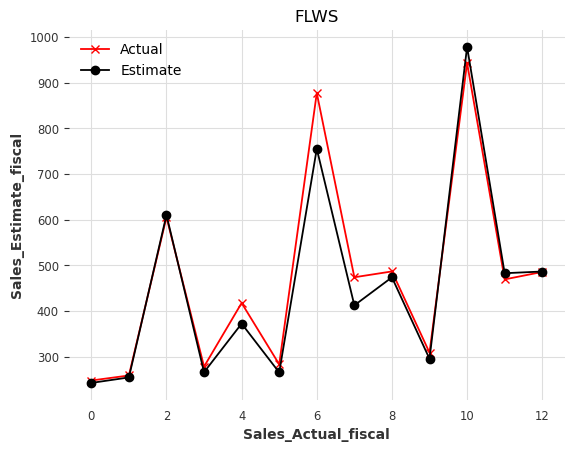

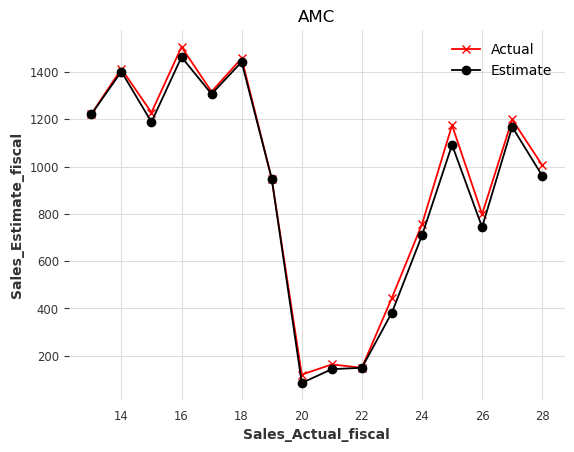

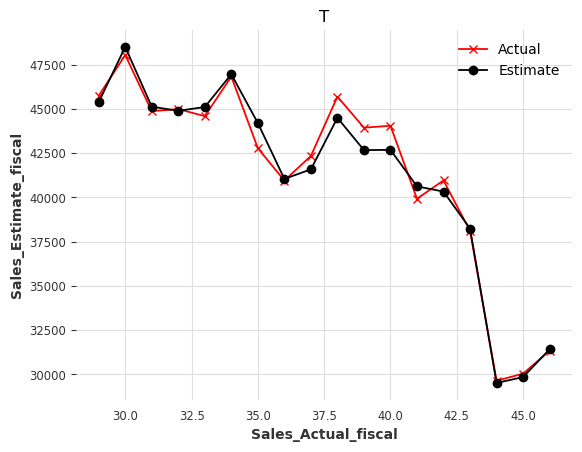

In [187]:
vis.plot_sales_comparison(df, max_plots=3)

It is evident that there are many instances for which the fiscal sales are missing for both estimate and actual. One could apply algorithms to impute this as before OLS, or other methods.  However, when a lot of columns is missing, it is hard to determine imputation. One could either look at a lot of companies within the same industry to perform a metric of similarity to determine imputation for those instances.

In [190]:
def impute_least_squares(df, company, column):
    """ 
    Imputes missing values in a column of a dataframe by OLS.

    Args:
        df (pd.DataFrame): dataframe of the entire dataset
        company (str): company ticker
        column (str): column for which the missing values are imputed
    
    Returns:
        df (pd.DataFrame): dataframe with imputed values
    """
    # get the subset of the dataframe which contains the company rows
    df_company = df[df['ticker'] == company]
    # get the index of the nan values
    nan_index = df_company[df_company[column].isna()].index
    # get the values of the other columns
    non_nan_index = df_company[df_company[column].notna()].index
    # create the X and y from the non nan values
    X = df_company.loc[non_nan_index, ['nw_total_sales_a_total', 'Sales_Estimate_fiscal', 'Sales_Actual_fiscal']]
    y = df_company.loc[non_nan_index, column]
    # add bias term to X
    X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    # get the coefficients
    weights = np.linalg.lstsq(X, y, rcond=None)[0]
    # predict the values for the nan values
    X_nan = df_company.loc[nan_index, ['nw_total_sales_a_total', 'Sales_Estimate_fiscal', 'Sales_Actual_fiscal']]
    X_nan = np.concatenate((np.ones((X_nan.shape[0], 1)), X_nan), axis=1)
    y_pred = np.dot(X_nan, weights)
    # replace the nan values with the predicted values
    df.loc[nan_index, column] = y_pred

    return df

def impute_normal_sample(df, company, column):
    """ 
    Imputes missing values in a column of a dataframe by sampling from a normal distribution.

    Args:
        df (pd.DataFrame): dataframe of the entire dataset
        company (str): company ticker
        column (str): column for which the missing values are imputed
    
    Returns:
        df (pd.DataFrame): dataframe with imputed values
    """
    assert column in ['Sales_Actual_fiscal', 'Sales_Estimate_fiscal']

    if column == 'Sales_Actual_fiscal':
        column_estimate = 'Sales_Estimate_fiscal'
    else:
        column_estimate = 'Sales_Actual_fiscal'
    
    # get the subset of the dataframe which contains the company rows
    df_company = df[df['ticker'] == company]
    # get the index of the nan values
    nan_index = df_company[df_company[column].isna()].index
    # get the values of the other columns
    non_nan_index = df_company[df_company[column].notna()].index
    
    # get the y estimate values at the nan index
    y_estimate = df_company.loc[nan_index, column_estimate]
    print(y_estimate, nan_index)
    # get the standard deviation as the difference between the estimate and the actual at the non nan index
    std = np.std(df_company.loc[non_nan_index, column] - df_company.loc[non_nan_index, column_estimate])
    y_pred = np.random.multivariate_normal(y_estimate, std * np.eye(len(y_estimate)) )
    # replace the nan values with the predicted values
    df.loc[nan_index, column] = y_pred

    return df

def impute_values(df):
    # get the list of companies with nan values
    nan_companies = dw.get_nan_columns(df)
    company_list_panel_B = nan_companies['nw_total_sales_b_total']
    company_list_panel_A = nan_companies['nw_total_sales_a_total']

    company_list_sales_actual = nan_companies['Sales_Actual_fiscal']
    company_list_sales_estimated = nan_companies['Sales_Estimate_fiscal']

    company_list = company_list_panel_B + company_list_panel_A + company_list_sales_actual + company_list_sales_estimated
    company_list = list(set(company_list))


    for company in company_list:
        # check if is in set b and not in actual, estimated, and a
        if company in company_list_panel_B and company not in company_list_sales_actual and company not in company_list_sales_estimated and company not in company_list_panel_A:
            df = impute_least_squares(df, company, 'nw_total_sales_b_total')
        # check if is in set a and not in set b, actual and estimated
        elif company in company_list_panel_A and company not in company_list_panel_B and company not in company_list_sales_actual and company not in company_list_sales_estimated:
            df = impute_least_squares(df, company, 'nw_total_sales_a_total')
        
        # check if is in actual and not in estimated
        elif company in company_list_sales_actual and company not in company_list_sales_estimated:
            df = impute_normal_sample(df, company, 'Sales_Actual_fiscal')
        
        # check if is in estimated and not in actual
        elif company in company_list_sales_estimated and company not in company_list_sales_actual:
            df = impute_normal_sample(df, company, 'Sales_Estimate_fiscal')
    
    return df

def run_imputation(df):
    """ 
    Iteratively imputes missing values in a dataframe.

    Args:
        df (pd.DataFrame): dataframe of the entire dataset
    
    Returns:
        df (pd.DataFrame): dataframe with imputed values
    """
    while True:
        n_nans = df.isna().sum().sum()
        df = impute_values(df)
        if n_nans == df.isna().sum().sum():
            return df


### Remaining NaNs

In [191]:
df.isna().sum()

mic                         0
ticker                      0
time                        0
nw_total_sales_a_total    193
nw_total_sales_b_total    133
Sales_Actual_fiscal       141
Sales_Estimate_fiscal     172
year                        0
month                       0
quarter                     0
dtype: int64

For many of the total sales in A and B these are overlapping. A strategy here could be to use KNN / KD-Balls, Decision Trees or other ML algorithms for imputations

In [192]:
dw.print_nans_companies(df)



Ticker: AAN, # Data points: 12
Column: Sales_Actual_fiscal, NaN Indices: [0, 1]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2]


Ticker: ABNB, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7]


Ticker: ACI, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6]


Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Ticker: ALGT, # Data points: 5
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 4]


Ticker: ALLY, # Data points: 1
Column: nw_total_sales_a_total, NaN Indices: [0]


Ticker: ASO, # Data points: 15
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 6, 7, 8, 11, 12, 14]
Column: Sales_

For some instances there are a lot of overlapping columns wih nans, so it could be hard to determine imputations single-handedly for that ticker. It could be worth investigating similar industries, as mentioned above. For now, we drop by row and keep the time series that have a "reasonable" length for making predictions.

In [193]:
# we can drop by row and then inspect the length of the individual tickers, and then drop really short sequences
df = df.dropna(axis=0, how='any')

In [194]:
for ticker in df['ticker'].unique():
    if len(df[df['ticker'] == ticker]) < 10:
        df = df[df['ticker'] != ticker]

In [195]:
df.ticker.unique()

array(['AMC', 'T', 'ANF', 'ATVI', 'ADBE', 'AAP', 'ACI', 'GOOGL', 'ATUS',
       'AMZN', 'AMXL', 'AAL', 'AEO', 'AAPL', 'ARMK', 'AZO', 'CAR', 'BJRI',
       'BJ', 'BP', 'BBWI', 'BBBY', 'BBY', 'BIG', 'SQ', 'BLMN', 'BKNG',
       'EAT', 'BBW', 'BURL', 'CVS', 'CAL', 'CTLP', 'CPRI', 'CCL', 'CRI',
       'CASY', 'CHTR', 'CAKE', 'CHGG', 'CVX', 'CHWY', 'CHS', 'CMG', 'CHH',
       'CMPR', 'CNK', 'CTRN', 'CMCSA', 'COP', 'COST', 'CBRL', 'CROX',
       'CUBE', 'DISH', 'DRI', 'PLAY', 'DAL', 'DENN', 'DBI', 'DKS', 'DDS',
       'DIN', 'DG', 'DLTR', 'DPZ', 'DKNG', 'DBX', 'DLTH', 'EA', 'EL',
       'ETSY', 'ES', 'EXPE', 'EXPR', 'XOM', 'FDX', 'FIVE', 'FVRR', 'FL',
       'FTV', 'FRG', 'GME', 'GPS', 'GEN', 'GM', 'GCO', 'GPC', 'GDDY',
       'GRPN', 'HOG', 'HLF', 'HLT', 'INTU', 'JACK', 'JBLU', 'KSS', 'AD',
       'MC', 'LYV', 'LOW', 'LYFT', 'M', 'MPC', 'MAR', 'MTCH', 'MCD',
       'META', 'MSFT', 'MGI', 'MUSA', 'NKE', 'NAVI', 'NFLX', 'NWL',
       'NDLS', 'JWN', 'ORLY', 'OLLI', 'OSTK', 'PVH', 'PZZA', 'PRTY

In [196]:
df.isna().sum()

mic                       0
ticker                    0
time                      0
nw_total_sales_a_total    0
nw_total_sales_b_total    0
Sales_Actual_fiscal       0
Sales_Estimate_fiscal     0
year                      0
month                     0
quarter                   0
dtype: int64

# Creating new columns with high correlation to target

In [197]:
df = dw.add_proportion_ab(df)
df = dw.add_quarterly_yoy(df)
df = dw.add_prod(df)

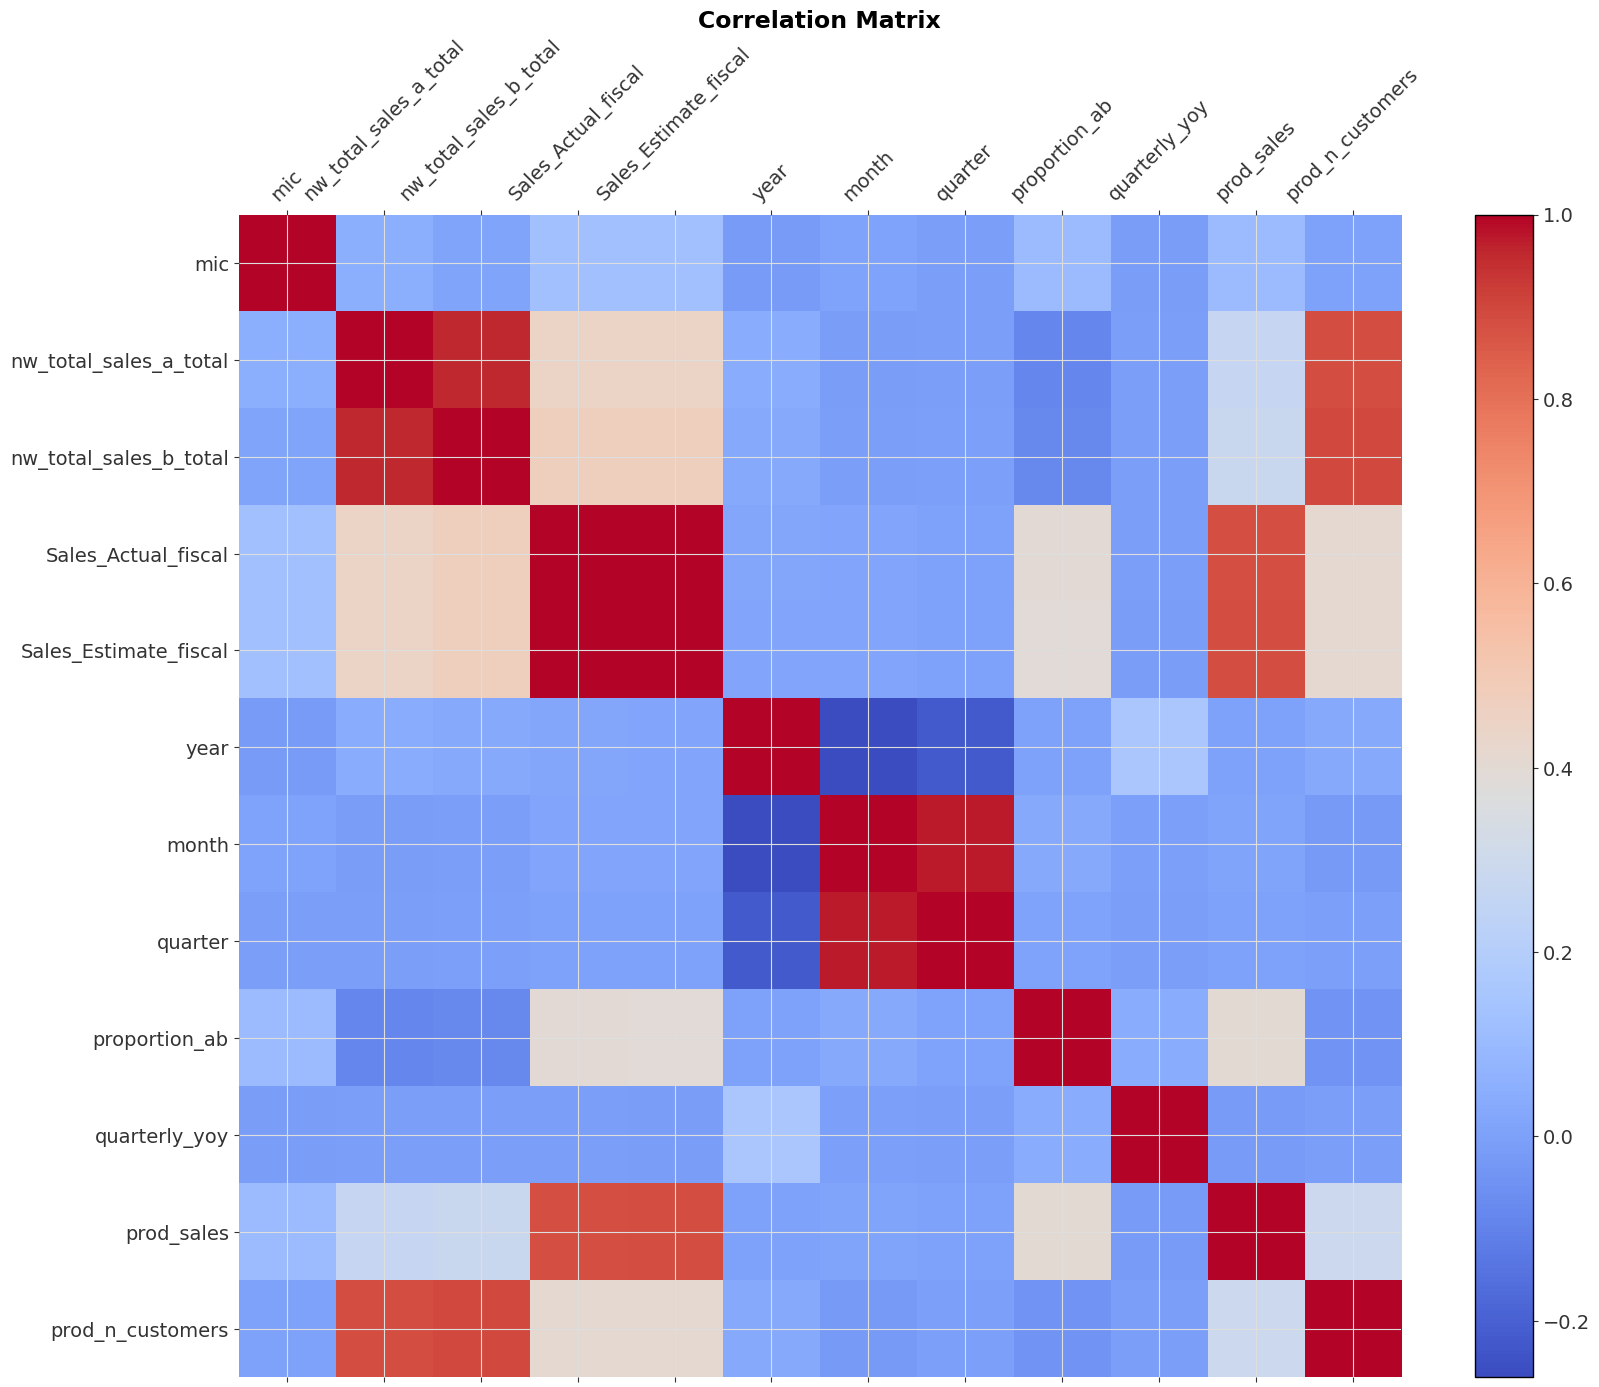

In [198]:
vis.plot_correlation_matrix(df)

The **key** to understanding here is that the high uncorrelation comes from the fact that we have a dataframe containing companies in different market segments with completely different scales to their sales by season, size of company etc., so looking at the whole dataframe gives a misleading correlation to the actual ground truth. If we take a single company, we can see that the correlation between columns will change drastically.

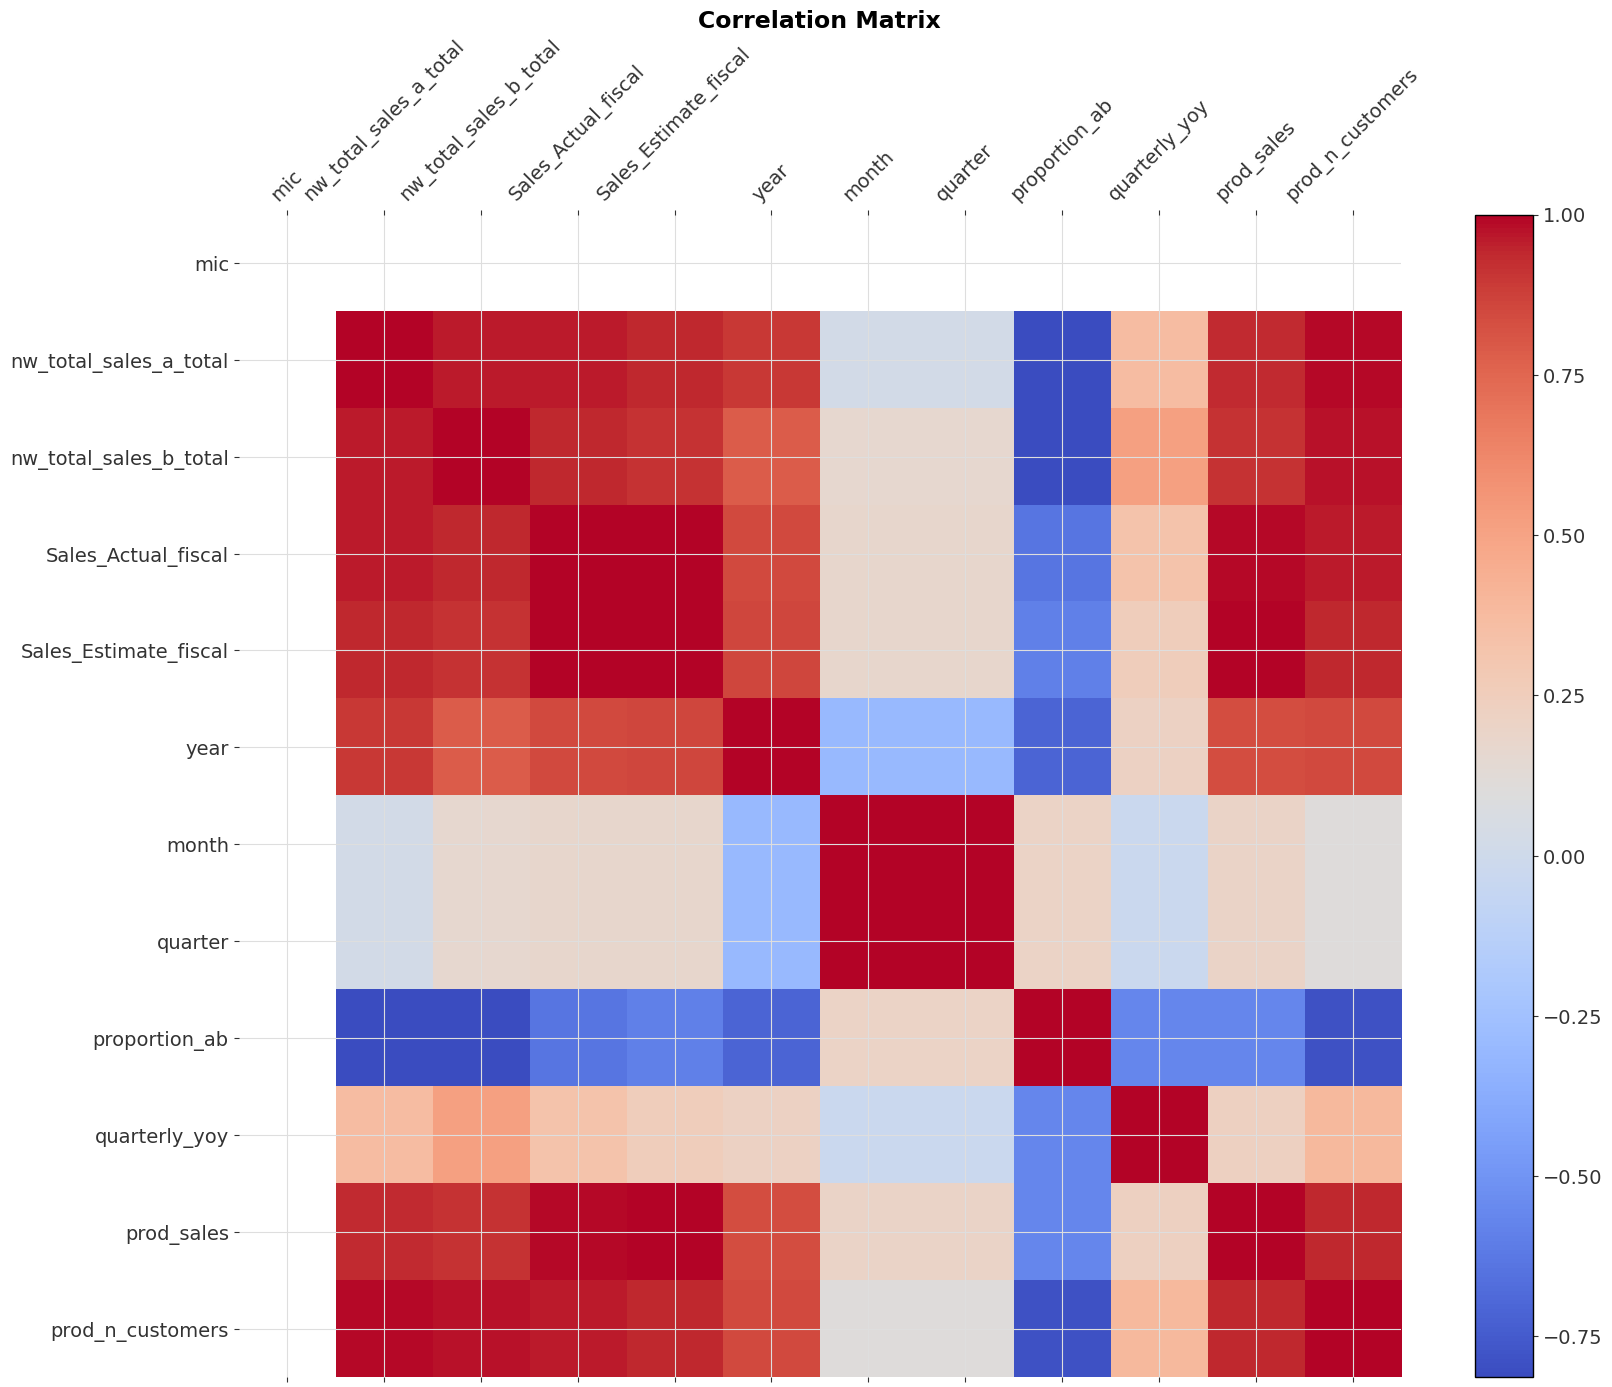

In [200]:
brand = 'AMZN'
df_brand = df[df['ticker'] == brand]
vis.plot_correlation_matrix(df_brand)

Therefore, the removal of columns is done by the respective ticker. If the overall mean covariance across all companies is below a threshold (set to 0.1), we remove it. Luckily for us there seem to be a very high correlation between actual sales to all other features

In [202]:
corr = df.groupby('ticker').apply(lambda x: x.corrwith(x['Sales_Actual_fiscal'], numeric_only=True)).mean()
corr = corr.sort_values(ascending=False)
corr


Sales_Actual_fiscal       1.000000
prod_sales                0.980363
Sales_Estimate_fiscal     0.956266
nw_total_sales_a_total    0.643779
prod_n_customers          0.631580
nw_total_sales_b_total    0.581755
quarterly_yoy             0.489508
year                      0.377857
proportion_ab             0.286347
quarter                   0.016101
month                     0.002080
mic                            NaN
dtype: float64

In [203]:
# function to drop low correlation features
df = dw.drop_low_correlation_features(df)


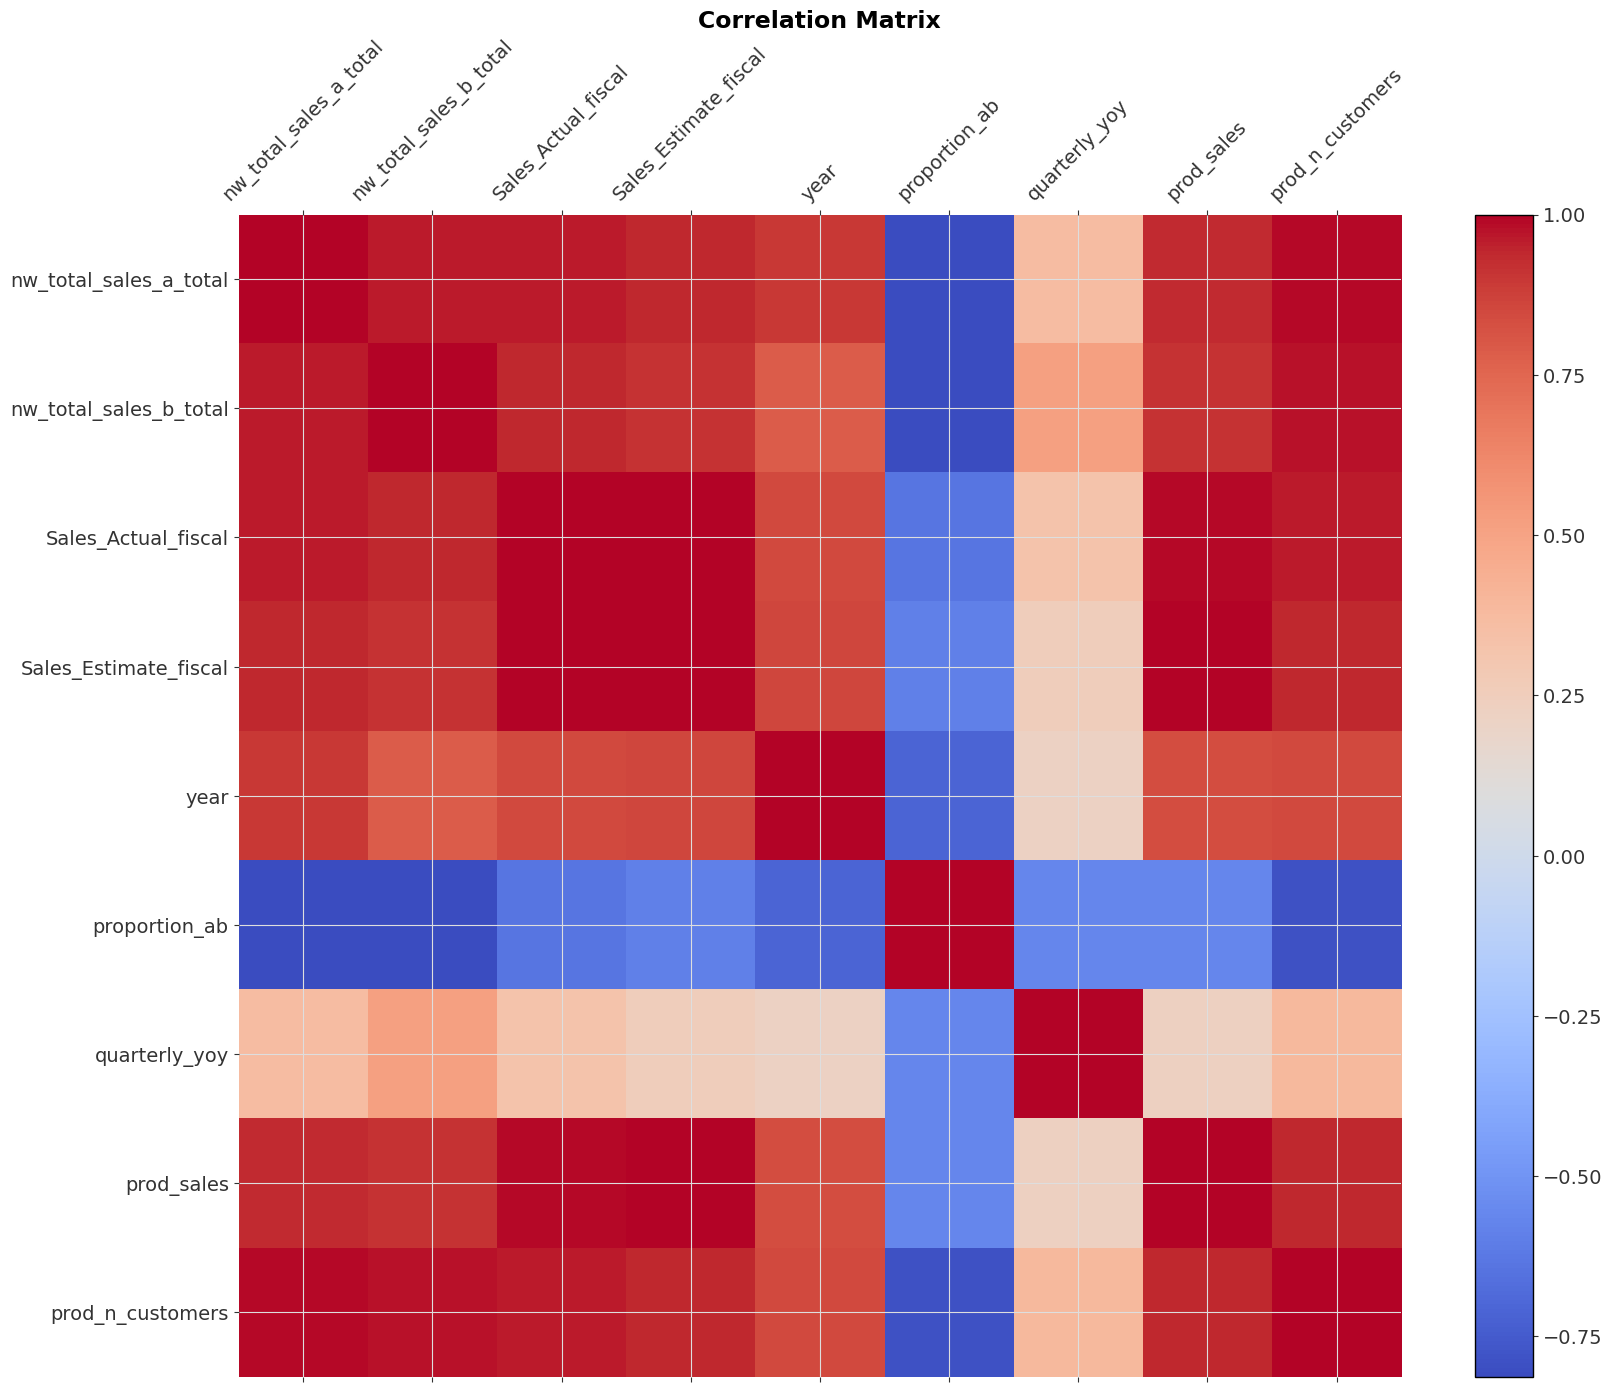

In [204]:
df_brand = df[df.ticker == 'AMZN']
vis.plot_correlation_matrix(df_brand)

The impact of covid and other macro economic events can have a significant impact on the sales. This we see in the reflection of the year's correlation with sales. An underlying factor for why this is so high is probably due to the effect of pre-mid-post COVID.

# Building Series in Darts
Note that the data frame must be thoroughly processed before starting this process, and keep in mind to that the model actually does handle NaNs implicitly. So, the thorough removal may not be neccessary. Especially, the line when all NaNs are dropped. Darts also has it's own models for imputations, but due to the structure of the data in this project, manual imputation using simple statistics was done.

As we create time series in darts, our model can support stationary covariates. As there is significant differences between companies in their sales volume, seasonalities, etc. we include this information to the model we are about to create. Thus, we must encode the stationary covariates, which we can do by mapping the tickers to a numeric value. To avoid numeric instability to the mapping, we do not do integer encoding as we have >200 companies to evaluate. This is to avoid any arbitrary ordering of assigning integer values. To have the model capture the stationary covariates there are two alternatives that seem reasonable:  
  
1. One Hot Encoding:   
Represent the tickers as one hot encoded covariates added to the function.
  
2. Mapping:  
Map the company to a range of somewhat similar float values to avoid numerical instability 
 
Now, because the number of companies exceeds the number of rows by a significant amount, it is uncertain whether the network will carry an advantage of adding so many stationary covariates. Thus, I have gone with option 2.

In [205]:
df, inv_mapper = dw.encode_float(df, 'ticker')

Functions above help extract appropriate covariates and target for each company within the data frame

### Converting the data frame into series for each company

In [206]:
series_dict = tsp.dict_series(df, inv_mapper)
past_cov, future_cov, target, tickers = tsp.past_future_split(series_dict, n_preds=1)
past_cov, future_cov, target, tickers = tsp.match_input_length(past_cov, future_cov, target, tickers, min_train = 12, pred_length=1)
past_cov, future_cov, target, scaler_cov, scaler_target = tsp.scale_series(past_cov, future_cov, target)

In the below line all lists have the corresponding index to the respective company.
I.e., If we look at;  

 ```train_past_cov[i], train_target[i], train_future_cov[i], tickers_train[i], scaler_cov_train[i], scaler_target_train[i]```

It corresponds to the same company $\forall i$

In [207]:
# Split the data into training and testing sets
train_past_cov, test_past_cov, \
train_future_cov, test_future_cov, \
train_target, test_target, \
tickers_train, tickers_test, \
scaler_cov_train, scaler_cov_test, \
scaler_target_train, scaler_target_test \
= tsp.train_test_split(
    past_cov,  # input feature data for past time steps in the training set
    future_cov,  # input feature data for future time steps in the training set
    target,  # target variable data in the training set
    tickers,  # ticker symbols for the data in the training set
    scaler_cov,  # scaler object to normalize the input feature data in the training set
    scaler_target,  # scaler object to normalize the target variable data in the training set
    test_size=0.2  # the proportion of the data to be used for testing
)

In [208]:
# remove points to predict from train and test data
train_target_input = tsp.remove_n_last_from_series(train_target, pred_length=1)
test_target_input = tsp.remove_n_last_from_series(test_target, pred_length=1)

# Base Line Models for Comparing to N-BEATS
## XGBoost, RandomForest, and Linear Regression
We list three models for what to compare against.
1. Linear Regression - simplest model available. strong linear dependencies and high correlations may prove that linear regression in fact does a good job at predicting future actual sales.
2. Random Forests (include references to why)
3. XGBoost (best performing for the task), include references. Beating XGBoost would be a high performing model.

We take two approaches. 
1. When we are forecasting a point estimate (i.e., one quarter into the future with $H = 1$) then we can include the future covariates to be all the variables we currently have access to, assuming open insight to our banks, analysts sales estimates, etc.
2. However, predicting $H > 1$ quarters, we do not have access to future covariates other than time dependencies, such as which quarter, year, month, etc.

Comparatively, we will see how (un)reliable these predictions come as we increase the forecast horizon, and how the models perform, the further away from the present time we go. 


In [209]:
from darts.models import XGBModel, RandomForest, LinearRegressionModel
from darts.metrics import rmse, mape, r2_score

In [210]:
train_target, train_past_cov, train_future_cov, \
train_target_input, train_tickers, train_scalers, \
val_target, val_past_cov, val_future_cov, val_input, \
val_tickers, val_scalers = tsp.split_train_val(target=train_target,
                                                past_cov=train_past_cov,
                                                future_cov=train_future_cov,
                                                input=train_target_input,
                                                tickers=tickers_train,
                                                scalers=scaler_target_train)                                                                               

# Tree Based Models

In [211]:
hp_opt = HyperparameterOptimization(train_target=train_target,
                                    train_past_cov=train_past_cov,
                                    train_future_cov=train_future_cov,
                                    val_target=val_target,
                                    val_past_cov=val_past_cov,
                                    val_future_cov=val_future_cov,
                                    val_input=val_input)

In [212]:
result_xgb, mapper_xgb = hp_opt.optimize(model='xgb', n_calls=10)
result_rf, mapper_rf = hp_opt.optimize(model='rf', n_calls=30)

 -------------------------------------------------
| 		 Model: xgb
|-------------------------------------------------
| 	 9 	 | 	 max_depth
 -------------------------------------------------
| 	 445 	 | 	 n_estimators
 -------------------------------------------------
| 	 3 	 | 	 n_jobs
 -------------------------------------------------
| 	 9 	 | 	 lags
 -------------------------------------------------
| 	 -11 	 | 	 lags_future_covariates
 -------------------------------------------------
| 	 0.082 	 | 	 learning_rate
 -------------------------------------------------
 -------------------------------------------------
| 		 Model: rf
|-------------------------------------------------
| 	 5 	 | 	 max_depth
 -------------------------------------------------
| 	 2 	 | 	 min_samples_split
 -------------------------------------------------
| 	 1 	 | 	 min_samples_leaf
 -------------------------------------------------
| 	 116 	 | 	 n_estimators
 ---------------------------------------------

In [213]:
xgb_model = XGBModel(**mapper_xgb)
rf_model = RandomForest(**mapper_rf)

In [214]:
xgb_model.fit(series=train_target,
              future_covariates=train_future_cov)
rf_model.fit(series=train_target,
             future_covariates=train_future_cov)

preds_train_xgb = xgb_model.predict(n=1, series=train_target_input, future_covariates=train_future_cov)
preds_val_xgb = xgb_model.predict(n=1, series=val_input, future_covariates=val_future_cov)
preds_test_xgb = xgb_model.predict(n=1, series=test_target_input, future_covariates=test_future_cov)

preds_train_rf = rf_model.predict(n=1, series=train_target_input, future_covariates=train_future_cov)
preds_val_rf = rf_model.predict(n=1, series=val_input, future_covariates=val_future_cov)
preds_test_rf = rf_model.predict(n=1, series=test_target_input, future_covariates=test_future_cov)

# Linear Regression

In [215]:
lin_reg_model = LinearRegressionModel(lags=12,
                                      lags_future_covariates=[k for k in range(-12,1)],
                                      output_chunk_length=1)
lin_reg_model.fit(series=train_target,
                  future_covariates=train_future_cov)

preds_train_lin_reg = lin_reg_model.predict(n=1, series=train_target_input, future_covariates=train_future_cov)
preds_val_lin_reg = lin_reg_model.predict(n=1, series=val_input, future_covariates=val_future_cov)
preds_test_lin_reg = lin_reg_model.predict(n=1, series=test_target_input, future_covariates=test_future_cov)


# N-BEATS Model

In [216]:
# Settings, not necessary at the moment
# lower and upper quantiles for predictions
QL1, QL2 = 0.01, 0.05 
QU1, QU2 = 1 - QL1, 1 - QL2 
# labels for plotting
labelQ1 = f'{int(QU1 * 100)} / {int(QL1 * 100)} percentile band'
labelQ2 = f'{int(QU2 * 100)} / {int(QL2 * 100)} percentile band'
seed = 42
quantiles=[0.01,0.05,0.5,0.95,0.99]

In [217]:
result_nbeats, mapper_nbeats = hp_opt.optimize(model='nbeats', n_calls=20)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.2 M 
---------------------------------------------------
1.2 M     Trainable params
955       Non-trainable params
1.2 M     Total params
9.786     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
skplt.plot_convergence(result_nbeats, label='nbeats')
skplt.plot_convergence(result_xgb, label='xgb')
skplt.plot_convergence(result_rf, label='rf')

In [ ]:
model_nbeats = NBEATSModel(**result_nbeats.x)

# Traininig plots

In [ ]:
vis.plot_predictions(pred_train, train_target, scaler_target_train, tickers_train)

# Test plots

In [ ]:
vis.plot_predictions(pred_test, test_target, scaler_target_test, tickers_test)

# Hyperparameter Tuning


### N-Beats / RNN (Architecture Design)  
https://unit8co.github.io/darts/examples/17-hyperparameter-optimization.html
* n_layers
* n_stacks
* input_chunk_length (lookback window of the model)
* output_chunk_length (how many steps into the future we make predictions)
* n past covariates to use
* n epochs in training
* layer width


In [44]:
from models import HyperparameterOptimizationNBEATS, HyperparameterOptimizationRandomForest


In [ ]:
hpopt_rf = HyperparameterOptimizationRandomForest(
                            train_target=train_target,
                            train_future_cov=train_future_cov,
                        )

In [ ]:
n_train = int(0.8 * len(train_target))
n_train

In [45]:
train_target[0][-1:]

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.09896379]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-12-31
  * component  (component) object 'Sales_Actual_fiscal'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates      ticker\ncomponent             ...
    hierarchy:          None

In [ ]:
hpopt = HyperparameterOptimizationNBEATS(
                                         max_input_length=len(train_past_cov[0]),
                                         output_length=2,
                                         train_target=train_target[:n_train],
                                         train_past_cov=train_past_cov[:n_train],
                                         val_target=train_target[n_train:],
                                         val_past_cov=train_past_cov[n_train:],
                                         val_input=train_target_input[n_train:])

result = hpopt.optimize(n_calls=10)